# [Item-based Collaborative filtering](https://velog.io/@zxxzx1515/%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-Item-based-collaborative-filtering-recommendation-algorithms)

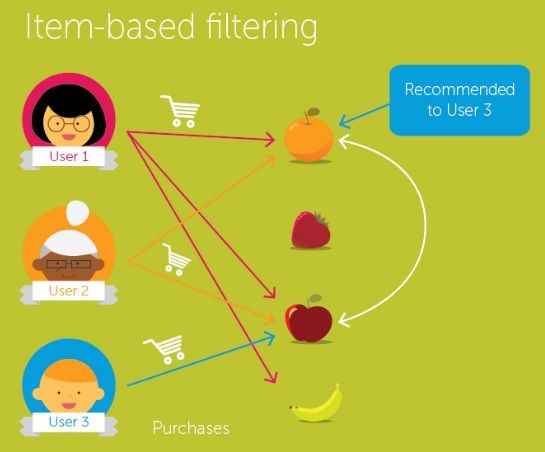

## 추천 과정 

User-based CF의 추천 과정 
1. 나랑 비슷한 노래를 듣는 사람들을 찾는다. 
2. 그 사람들이 좋아하는 노래를 뽑아낸다.
3. 내가 아직 들은 적이 없다면, 나에게 추천해준다.

Item-based CF의 추천 과정 
1. 데이터베이스에 존재하는 모든 노래들에 대해 비슷한 노래들을 미리 찾는다. 
2. 1번에서 찾은 것을 바탕으로 내가 좋아할 법한 노래를 뽑는다. 
3. 내가 아직 들은 적이 없다면, 나에게 추천해준다.

## User-based CF의 단점 

- 결국 item-based CF든 user-based CF든 2번, 3번은 비슷하지만, 1번에서 미리 계산을 해 놓을 수 있는지의 대한 여부가 차이가 난다. 
- 나는 지금 힙합을 좋아하지만, 당장 한달 뒤에는 발라드를 듣고 있을 수 있다. 즉, 나와 비슷한 사람의 집단이 계속해서 바뀌 수 있다는 것이다. 
- 하지만 item의 경우에는 한번 출시된 음악은 비슷한 음악의 집단이 바뀔 가능성이 상대적으로 낮다. 

따라서 user의 경우 비슷한 집단(neighbors)를 미리 계산할 수 없지만, item의 경우 neighbors를 미리 계산 해놓을 수 있는 것이다. 즉, 추천이 빨라진다.!!!

## Item-based CF Algorithm

용어 및 기호들 정리 

- m명의 유저:    
$u = \{u_1, u_2, ..., u_m\}$
- n개의 아이템:   
$I = \{i_1, i_2, ..., i_n\}$
- 유저 $u_i$가 어떤 아이템들을 선택했을 때,    
  - $I_{u_i}$
  - $I_{u_i} \subseteq I$이고, 공집합 $\phi$일 수도 있다.
- active user라고 부르는 $u_a$를 추천해주고 싶은 유저라고 정의한다면, 아이템은 2가지 방법으로 찾는다. 
  - `Prediction`: $P_{aj}$라고 하는 숫자를 계산해보자.     
  어떤 아이템 $i_j \not\subset I_{u_a}$(즉, $u_a$가 아직 안고른 아이템)에 대해서 유저가얼마나 좋아할지에 대한 예상  
  - `Recommendation`: $I_n$(N개의 추천 아이템 리스트)       
  $I_n \subset I$이고, $u_a$가 제일 좋아할 것 같은 아이템들의 집합이다. 또한 아직 구매를 하지 않은 집합이기도 하다. ($I_n \cap I_{u_a} = \phi$)

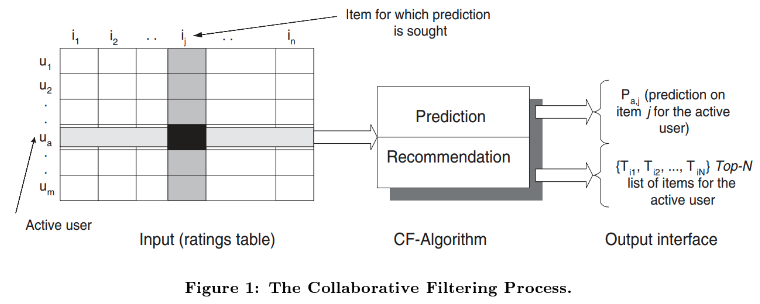

# [Movie Dataset](https://grouplens.org/datasets/movielens/)

In [ ]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats
# Visualization
import seaborn as sns

## 데이터 로드 

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/Movie/ml-1m/"

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
ratings = pd.read_csv(DATA_PATH+'ratings.csv')

print(f'{ratings.shape}')
ratings.head(2)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [ ]:
movies = pd.read_csv(DATA_PATH+'movies_metadata.csv')

print(f'{movies.shape}')
movies.head(2)

(45466, 24)


<ipython-input-12-6bcb0af2c92d>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(DATA_PATH+'movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


- 데이터 가공 

In [ ]:
from ast import literal_eval

In [ ]:
movies['genres'] = movies['genres'].apply(literal_eval)
movies['genres'] = movies['genres'].map(lambda x: [y['name'] for y in x])
movies['genres'] = movies['genres'].apply(lambda x: (' ').join(x))

movies.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


## 데이터 합치기 

In [ ]:
movies = movies.rename(columns={'id':'movieId'})
movies['movieId'] = movies['movieId'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)

df = pd.merge(ratings, movies[['movieId', 'title', 'genres']], how='inner', on='movieId')

print(df.shape)
df.head(2)

(44994, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,1371,2.5,1260759135,Rocky III,Drama
1,4,1371,4.0,949810302,Rocky III,Drama


## EDA

In [ ]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(
    mean_rating = ('rating', 'mean'), number_of_ratings = ('rating', 'count')).reset_index()

print(agg_ratings.shape)
agg_ratings.head(2)

(2794, 3)


,title,mean_rating,number_of_ratings
0,!Women Art Revolution,3.25,2
1,'Gator Bait,0.50,1


In [ ]:
# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

print(agg_ratings_GT100.shape)
agg_ratings_GT100.head(2)

(82, 3)


,title,mean_rating,number_of_ratings
37,48 Hrs.,3.9025,200
38,5 Card Stud,4.1825,200


In [ ]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
1959,Terminator 3: Rise of the Machines,4.256173,324
2306,The Million Dollar Hotel,4.487138,311
1837,Solaris,4.134426,305
1967,The 39 Steps,4.221649,291
1374,Monsoon Wedding,3.706204,274


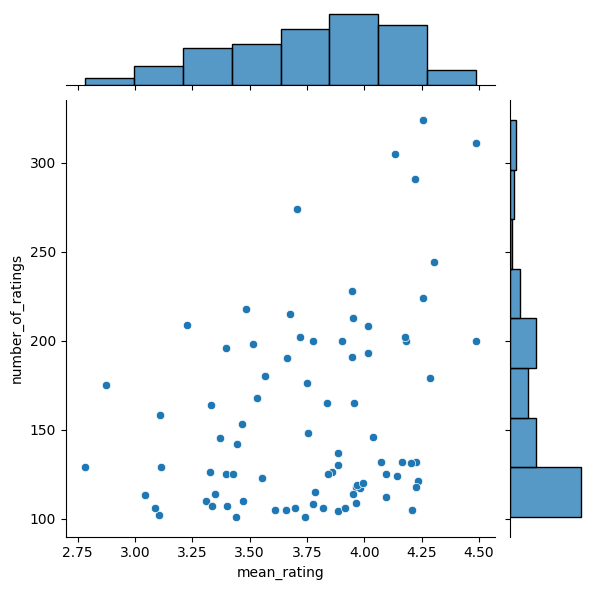

In [ ]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [ ]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')

print(df_GT100.shape)
df_GT100.head()

(12830, 6)


,userId,movieId,rating,timestamp,title,genres
0,2,110,4.0,835355532,Three Colors: Red,Drama Mystery Romance
1,3,110,4.0,1298922049,Three Colors: Red,Drama Mystery Romance
2,7,110,5.0,851868188,Three Colors: Red,Drama Mystery Romance
3,8,110,4.0,1154473268,Three Colors: Red,Drama Mystery Romance
4,13,110,4.0,1331380038,Three Colors: Red,Drama Mystery Romance


# [Model V1 with Cosine Similarity](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)

## user-movie matrix
- we will transform the dataset into a matrix format. 
- The rows of the matrix are movies, and the columns of the matrix are users. 
- The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows ‘NaN’.

In [ ]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')

print(matrix.shape)
matrix.head()

(82, 657)


userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,3.0,NaN
5 Card Stud,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0
A Clockwork Orange,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN
A Nightmare on Elm Street,3.0,2.5,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,NaN,3.0,NaN,NaN,NaN,NaN
A River Runs Through It,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## data normalization
- we will normalize the data by subtracting the average rating of each movie. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.
- After normalization, the ratings less than the movie’s average rating get a negative value, and the ratings more than the movie’s average rating get a positive value.

In [ ]:
matrix.mean(axis=1)

title
48 Hrs.                          3.902500
5 Card Stud                      4.182500
A Clockwork Orange               3.102941
A Nightmare on Elm Street        3.566667
A River Runs Through It          4.071970
                                   ...   
Twin Peaks: Fire Walk with Me    3.552846
Under the Sand                   4.096000
Wag the Dog                      3.112403
Who Killed Bambi?                3.044248
Young and Innocent               4.018135
Length: 82, dtype: float64

In [ ]:
# subtract: rating - mean
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)

print(matrix_norm.shape)
matrix_norm.head()

(82, 657)


userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,1.097500,NaN,NaN,0.097500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.097500,NaN,NaN,NaN,0.097500,0.097500,NaN,NaN,-0.9025,NaN
5 Card Stud,NaN,NaN,NaN,NaN,NaN,NaN,-0.6825,NaN,NaN,NaN,...,NaN,NaN,-0.182500,0.817500,NaN,NaN,NaN,NaN,NaN,0.8175
A Clockwork Orange,-0.102941,NaN,-0.102941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.897059,NaN,NaN,NaN,-0.102941,-0.102941,NaN,NaN,NaN,NaN
A Nightmare on Elm Street,-0.566667,-1.066667,NaN,0.433333,NaN,-0.566667,NaN,NaN,NaN,NaN,...,0.433333,NaN,0.433333,-0.566667,NaN,-0.566667,NaN,NaN,NaN,NaN
A River Runs Through It,NaN,NaN,NaN,NaN,0.92803,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.428030,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Similarity Score(유사도)

### Pearson Correlation

In [ ]:
matrix_norm.T.head()

title,48 Hrs.,5 Card Stud,A Clockwork Orange,A Nightmare on Elm Street,A River Runs Through It,All the Way Boys,And Then There Were None,Ariel,Arlington Road,Back to the Future Part II,...,The Tunnel,Three Colors: Red,Titanic,To Kill a Mockingbird,Tough Enough,Twin Peaks: Fire Walk with Me,Under the Sand,Wag the Dog,Who Killed Bambi?,Young and Innocent
userId,,,,,,,,,,,,,,,,,,,,,
2,1.0975,NaN,-0.102941,-0.566667,NaN,NaN,NaN,NaN,NaN,-0.443662,...,NaN,0.054825,NaN,NaN,NaN,NaN,NaN,-0.112403,NaN,NaN
3,NaN,NaN,NaN,-1.066667,NaN,1.167683,NaN,NaN,NaN,NaN,...,NaN,0.054825,NaN,-1.75,NaN,NaN,NaN,NaN,NaN,-0.518135
4,NaN,NaN,-0.102941,NaN,NaN,NaN,NaN,NaN,1.246622,NaN,...,NaN,NaN,0.736264,NaN,0.915094,NaN,NaN,NaN,0.955752,NaN
5,0.0975,NaN,NaN,0.433333,NaN,0.667683,NaN,NaN,NaN,NaN,...,NaN,NaN,1.736264,0.25,NaN,0.947154,NaN,0.887597,NaN,-0.518135
6,NaN,NaN,NaN,NaN,0.92803,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()

print(item_similarity.shape)
item_similarity.head()

(82, 82)


title,48 Hrs.,5 Card Stud,A Clockwork Orange,A Nightmare on Elm Street,A River Runs Through It,All the Way Boys,And Then There Were None,Ariel,Arlington Road,Back to the Future Part II,...,The Tunnel,Three Colors: Red,Titanic,To Kill a Mockingbird,Tough Enough,Twin Peaks: Fire Walk with Me,Under the Sand,Wag the Dog,Who Killed Bambi?,Young and Innocent
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,1.000000,1.432026e-01,0.245961,0.285867,1.065216e-01,0.464661,0.242641,0.353910,0.170418,0.215400,...,0.258414,0.281766,0.300282,-0.084330,0.324018,0.361374,0.448090,0.379924,0.392057,0.251019
5 Card Stud,0.143203,1.000000e+00,-0.018358,0.244633,-2.020017e-19,0.065894,0.299084,0.106273,0.022668,0.271883,...,0.379034,0.241973,0.123183,0.380184,0.337276,-0.001594,0.057261,0.024973,0.094909,0.227639
A Clockwork Orange,0.245961,-1.835767e-02,1.000000,0.365163,-8.065628e-02,0.399735,0.299874,0.435859,0.028836,0.420984,...,0.174030,0.121086,0.516142,0.256014,0.578334,0.094171,0.174595,0.270488,0.251387,0.242673
A Nightmare on Elm Street,0.285867,2.446329e-01,0.365163,1.000000,8.918877e-03,0.352560,0.412809,0.363562,0.065121,0.244692,...,0.217156,0.099401,0.454536,0.057581,0.503554,0.227704,0.155487,0.323967,0.225427,0.066272
A River Runs Through It,0.106522,-2.020017e-19,-0.080656,0.008919,1.000000e+00,0.056576,0.068525,0.188261,0.273697,0.230630,...,0.327849,0.037180,-0.037888,0.225025,0.074046,0.064813,0.158386,-0.235998,0.209828,-0.140548


### Cosine Similarity

In [ ]:
# Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))

print(item_similarity_cosine.shape)
item_similarity_cosine

(82, 82)


array([[ 1.        ,  0.03905888,  0.1145175 , ...,  0.15574153,
         0.13793603,  0.08013098],
       [ 0.03905888,  1.        , -0.00410561, ...,  0.01181875,
         0.02420211,  0.13600676],
       [ 0.1145175 , -0.00410561,  1.        , ...,  0.11526176,
         0.07705209,  0.0820372 ],
       ...,
       [ 0.15574153,  0.01181875,  0.11526176, ...,  1.        ,
         0.19383855,  0.11085199],
       [ 0.13793603,  0.02420211,  0.07705209, ...,  0.19383855,
         1.        ,  0.17303441],
       [ 0.08013098,  0.13600676,  0.0820372 , ...,  0.11085199,
         0.17303441,  1.        ]])

## 영화 추천  

In [ ]:
matrix_norm.head(2)

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,1.0975,NaN,NaN,0.0975,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0975,NaN,NaN,NaN,0.0975,0.0975,NaN,NaN,-0.9025,NaN
5 Card Stud,NaN,NaN,NaN,NaN,NaN,NaN,-0.6825,NaN,NaN,NaN,...,NaN,NaN,-0.1825,0.8175,NaN,NaN,NaN,NaN,NaN,0.8175


In [ ]:
# Pick a user ID
picked_userid = 2

In [ ]:
# matrix_norm[picked_userid]

In [ ]:
# pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
#                           .sort_values(ascending=False))\
#                           .reset_index()

In [ ]:
# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={picked_userid:'rating'})
picked_userid_watched.head()

,title,rating
0,The Conversation,1.602041
1,The Hours,1.282178
2,Lost in Translation,1.217054
3,48 Hrs.,1.097500
4,Live and Let Die,0.604000


In [ ]:
# Pick a movie
picked_movie = '5 Card Stud'

In [ ]:
# item_similarity[[picked_movie]]

In [ ]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                            right=picked_movie_similarity_score, 
                                            on='title', 
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]
# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

,title,rating,similarity_score
1,The Hours,1.282178,0.362272
21,Batman Returns,-0.777500,0.337609
7,Monsoon Wedding,0.293796,0.332549
18,Back to the Future Part II,-0.443662,0.271883
17,Night on Earth,-0.440594,0.267913


In [ ]:
picked_userid_watched_similarity['rating']

1     1.282178
21   -0.777500
7     0.293796
18   -0.443662
17   -0.440594
Name: rating, dtype: float64

In [ ]:
picked_userid_watched_similarity['similarity_score']

1     0.362272
21    0.337609
7     0.332549
18    0.271883
17    0.267913
Name: similarity_score, dtype: float64

In [ ]:
np.average(picked_userid_watched_similarity['rating'], 
                                    weights=picked_userid_watched_similarity['similarity_score'])

0.03882537531169269

In [ ]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)
print(f'The predicted rating for "{picked_movie}" by user "{picked_userid}" is {predicted_rating}' )

The predicted rating for "5 Card Stud" by user "2" is 0.038825


In [ ]:
# Item-based recommendation function
def item_based_rec(picked_userid=2, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[2]==True]['title'].values.tolist()
  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={2:'rating'})
  
  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}  
  # Loop through unwatched movies          
  for picked_movie in picked_userid_unwatched: 
    # Calculate the similarity score of the picked movie iwth other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                                right=picked_movie_similarity_score, 
                                                on='title', 
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

In [ ]:
# Get recommendations
recommended_movie = item_based_rec(picked_userid=2, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie

[('Boogie Nights', 0.615916),
 ('All the Way Boys', 0.525854),
 ('Say Anything...', 0.460177)]

# [Model V2 with MSE](https://hipster4020.tistory.com/114?category=856880)

## [데이터 로드](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset?select=Book+reviews)

In [ ]:
import numpy as np 
import pandas as pd 

from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics import mean_squared_error 

In [ ]:
DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/Book reviews/"

bxbooks = pd.read_csv(DATA_PATH+'BX_Books.csv', sep= ';', encoding="latin-1")
bxbookratings = pd.read_csv(DATA_PATH+'BX-Book-Ratings.csv', sep= ';', encoding="latin-1")

bxbooks.shape, bxbookratings.shape 

((271379, 8), (1149780, 3))

In [ ]:
bxbooks.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [ ]:
bxbookratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### 결측치 확인 

In [ ]:
bxbooks.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [ ]:
bxbookratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
bxbooks.shape, bxbookratings.shape 

((271379, 8), (1149780, 3))

### 데이터 사이즈 조정 
- bxbookratings 데이터는 사용자별로 도서에 대한 평점을 매긴 데이터 세트입니다. 이것 역시 데이터 건수가 너무 많아 50,000으로 줄이겠습니다.  

In [ ]:
# 데이터 사이즈 조정
bxbookratings = bxbookratings[:50000]

bxbooks.shape, bxbookratings.shape

((271379, 8), (50000, 3))

## 도서간 유사도 산출 

### pivot_table 생성 
협헙 필터링은 사용자와 아이템 간의 평점(또는 다른 유형의 액션)에 기반해 추천하는 시스템입니다. 먼저 DataFrame의 pivot_table()를 이용하여 로우(행) 레벨 데이터의 원본 데이터 세트를 모든 사용자를 로우로, 모든 도서를 컬럼으로 구성하는 데이터 세트로 변경해야 합니다.

In [ ]:
# title 컬럼을 얻기 위해 movies와 조인
rating_books = pd.merge(bxbookratings, bxbooks, on='ISBN')

print(f'{rating_books.shape}')
rating_books.head()

(43975, 10)


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [ ]:
# columns='title'로 title 컬럼으로 피벗 수행.
ratings_matrix = rating_books.pivot_table('Book-Rating', index='User-ID', columns='Book-Title')

print(f'{ratings_matrix.shape}')
ratings_matrix.head()

(4374, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 거의 모든 데이터가 NaN으로 보이는 이유는 사용자가 평점을 매기지 않은 도서가 컬럼으로 변환되면서 NaN으로 할당되었기 때문입니다.   
- NaN 데이터를 처리하기 전에, ISBN 값을 각각 해당하는 bxbooks 데이터 세트에 있는 도서명으로 변경하겠습니다.
- bxbookratings와 bxbooks를 조인해 Book-Title 컬럼을 가지고 다시 피벗(pivot)한 후에 NaN은 0으로 변환합니다.

In [ ]:
# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)

print(f'{ratings_matrix.isnull().sum().sum()}')
ratings_matrix.head()

0


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 유사도 산출

변환된 사용자-아이템 테이블을 사이킷런의 cosine_similarity()를 이용하여 코사인 유사도를 기반으로 측정합니다.    

cosine_similarity()는 아이템 행을 기준으로 서로 다른 행을 비교해 유사도를 산출합니다.
- 아이템을 기준으로 cosine_similarity()를 적용하려면 행 기준 : 아이템, 열 기준 : 사용자가 되어야 하는데, 현재 생성한 ratings_matrix 테이블은 사용자-아이템 기반임으로 행과 열을 변경해야 합니다.  
- 전치 행렬 변경을 위해 pandas의 transpose()를 이용하여 ratings_matrix 데이터의 행과 열 위치를 변경합니다.  

In [ ]:
ratings_matrix_T = ratings_matrix.transpose()

print(f'{ratings_matrix_T.shape}')
ratings_matrix_T.head()

(28726, 4374)


User-ID,2,8,9,10,12,14,16,17,19,20,...,278832,278836,278838,278843,278844,278846,278849,278851,278852,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
Beyond IBM: Leadership Marketing and Finance for the 1990s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
It Takes Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mystery Mile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tales of Terror and Suspense,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


생성된 전치 행렬 데이터 세트를 토대로 코사인 유사도를 측정하겠습니다.

In [ ]:
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T) 

item_sim.shape 

(28726, 28726)

In [ ]:
# cosine_similarity()로 반환된 Numpy 행렬을 도서명으로 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head()

(28726, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
Book-Title,,,,,,,,,,,,,,,,,,,,,
Beyond IBM: Leadership Marketing and Finance for the 1990s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
It Takes Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mystery Mile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tales of Terror and Suspense,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


101 Dalmatians을 기준으로 유사도가 높은 상위 5건 추출해보겠습니다.

In [ ]:
item_sim_df["101 Dalmatians"].sort_values(ascending=False)[:5]

Book-Title
101 Dalmatians                                   1.000000
The White Dragon (Dragonriders of Pern Vol 3)    0.780869
MISS PYM DISPOSES                                0.780869
Olive and the Magic Hat                          0.780869
Vanishing Point: A Miss Silver Mystery           0.780869
Name: 101 Dalmatians, dtype: float64

1984을 기준으로 확인해보겠습니다.

In [ ]:
item_sim_df["1984"].sort_values(ascending=False)[:5]

Book-Title
1984                                                                                                         1.000000
The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)                                     0.464057
The Ethical Slut: A Guide to Infinite Sexual Possibilities                                                   0.391931
The Tao of Love and Sex                                                                                      0.391931
The Western Guide to Feng Shui: Creating Balance, Harmony, and Prosperity in Your Environment (Feng Shui)    0.391931
Name: 1984, dtype: float64

## 개인화된 도서 추천

개인이 아직 읽지 않은 도서에 대해 아이템 유사도와 기존에 읽은 도서의 평점 데이터를 가지고 다른 모든 도서의 예측 평점을 계산한 후 높은 예측 평점을 가진 도서를 추천하는 방식입니다.  

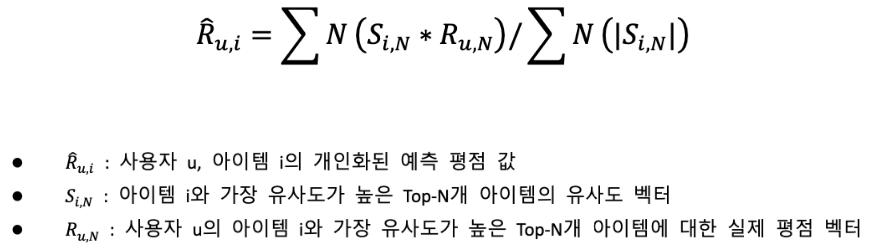

In [ ]:
# 예측 평점 계산식 함수 구현
def predict_rating(ratings_arr, item_sim_arr):

    # dot : 내적을 이용한 가중합 계산
    ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [ ]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)

<ipython-input-76-b78cd84be24e>:5: RuntimeWarning: invalid value encountered in divide
  ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])


In [ ]:
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, 
                                   columns = ratings_matrix.columns)

print(f'{ratings_pred_matrix.shape}')
ratings_pred_matrix.head()

(4374, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN
8,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.001942,0.001966,NaN,NaN,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN
10,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN
12,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN


### 예측 평가 지표(MSE, Mean Squared Errors)

In [ ]:
# 사용자가 평점을 부여한 도서에 대해서만 예측 성능 평가 MSE를 구한다.
def get_mse(pred, actual):
    # 평점이 있는 실제 도서만 추출
    pred = pred[actual.nonzero()]
    actual = actual[actual.nonzero()]
    return mean_squared_error(pred, actual)

In [ ]:
print('MSE : ', get_mse(ratings_pred, ratings_matrix.values ))

MSE :  15.572293628480582


실제 값과 예측 값이 범위의 차이로 예측 평가 지수인 MSE 값은 크게 나올 수가 있습니다.    
따라서 MSE 값을 감소하기 위해 특정 도서와 가장 비슷한 유사도를 가지는 도서에 대해서만 유사도 벡터를 적용하는 함수를 다음으로 구현합니다.

In [ ]:
from tqdm.auto import tqdm

# 특정 도서와 가장 비슷한 유사도를 가지는 도서에 대해서만 유사도 벡터를 적용하는 예측 평점 계산식 함수 구현
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):

    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)
    
    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행.
    for col in tqdm(range(ratings_arr.shape[1])):
        
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row,
                                                                   :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
            
    return pred

유사도가 가장 비슷한 도서에 대해서만 유사도 벡터를 적용한 예측 평점 함수를 이용하여 예측 평점을 계산하고, 실제 평점과 MSE를 구해보겠습니다.  
계산된 예측 평점 Numpy 형렬은 DataFrame으로 변경합니다.

In [ ]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)

print('아이템 기반 추천 with MSE : ', get_mse(ratings_pred, ratings_matrix.values))

  0%|          | 0/28726 [00:00<?, ?it/s]

<ipython-input-81-3336fb1aa1a5>:19: RuntimeWarning: invalid value encountered in scalar divide
  pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))


아이템 기반 최근접 Top-20 이웃 MSE :  11.823075609279435


In [ ]:
print(ratings_pred.shape)
ratings_pred

(4374, 28726)


array([[nan, nan, nan, ..., nan,  0., nan],
       [nan, nan, nan, ..., nan,  0., nan],
       [nan, nan, nan, ..., nan,  0., nan],
       ...,
       [nan, nan, nan, ..., nan,  0., nan],
       [nan, nan, nan, ..., nan,  0., nan],
       [nan, nan, nan, ..., nan,  0., nan]])

In [ ]:
# 계산된 예측 평점 데이터를 DataFrame으로 변경
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)

print(f'{ratings_pred_matrix.shape}')
ratings_pred_matrix.head()

(4374, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
8,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
10,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
12,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN


### 도서 추천
특정 사용자 아이디(277928)를 이용하여 도서 추천을 진행해 보겠습니다.   
사용자가 평점을 매긴 도서를 토대로 평점이 높은 순으로 내림차순 나열하겠습니다.

In [ ]:
user_rating_id = ratings_matrix.loc[277928, :]
user_rating_id[ user_rating_id > 0 ].sort_values(ascending=False)[:10]

Book-Title
What the Dogs Have Taught Me, and Other Amazing Things I'Ve Learned          10.0
Italian Neighbors Or, a Lapsed Anglo-Saxon in Verona                         10.0
Depth Takes a Holiday: Essays from Lesser Los Angeles                        10.0
Sleeping at the Starlite Motel: And Other Adventures on the Way Back Home    10.0
Pumping Irony: Working Out the Angst of a Lifetime                           10.0
Mama Makes Up Her Mind: And Other Dangers of Southern Living                 10.0
Smilla's Sense of Snow                                                        9.0
Bill Bryson's African Diary                                                   9.0
It Was on Fire When I Lay Down on It                                          9.0
Lytton Strachey: The New Biography                                            8.0
Name: 277928, dtype: float64

사용자가 이미 평점을 매긴 도서를 제외하고 추천할 수 있도록 아직 평점을 주지 않은 도서를 리스트 객체로 반환하는 함수를 구현해보겠습니다.

In [ ]:
def get_unseen_books(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 도서 정보를 추출해 Series로 반환함.
    # 반환된 user_ratings은 도서명(title)을 인덱스로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId, :]
    
    # user_rating이 0보다 크면 기존에 읽은 도서. 대상 인덱스를 추출해 list 객체로 만듦.
    already_seen = user_rating[ user_rating>0 ].index.tolist()
    
    # 모든 도서명을 list 객체로 만듦.
    book_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 도서는 books_list에서 제외함.
    unseen_list = [ book for book in book_list if book not in already_seen ]
    
    return unseen_list

사용자가 아직 평점을 주지 않은 추천 대상 도서 정보와 predict_rating_tipsim()에서 추출한 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 도서를 추천하는 함수를 구현해 보겠습니다.

In [ ]:
def recomm_book_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 도서명 칼럼을 추출해 가장 예측 평점이 높은 순으로 정렬함.
    recomm_books = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_books

In [ ]:
# 사용자가 관람하지 않은 도서명 추출
unseen_list = get_unseen_books(ratings_matrix, 277928)

In [ ]:
# 아이템 기반의 최근접 이웃 협업 필터링으로 도서 추천
recomm_books = recomm_book_by_userid(ratings_pred_matrix, 277928, unseen_list, top_n=10)

In [ ]:
# 평점 데이터를 DataFrame으로 생성
recomm_books = pd.DataFrame(data=recomm_books.values, index=recomm_books.index, columns=['pred_score'])

recomm_books

,pred_score
Book-Title,
Invasion of Privacy,0.475185
Missing in Manhattan: The Adams Round Table,0.464747
"NIGHT SHE DIED, THE",0.464747
The Witness for the Prosecution and Other Stories,0.464747
The Butter Did It : A Gastronomic Tale of Love and Murder (Chas Wheatley Mysteries),0.464747
Murder at the PTA Luncheon,0.464747
The Deep End of the Ocean (Oprah's Book Club),0.463535
Deep Lie,0.437176
Suspicion of Vengeance,0.311130


# [Model V3 with NearestNeighbors](https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab)

최근접 이웃 협업 필터링은 사용자 기반과 아이템 기반으로 분류하는데, 이 중 일반적으로 추천 정확도가 더 뛰어난 아이템 기반의 협업 필터링을 구현해 보겠습니다.    

매우 유명한 아이템은 취향과 관계없이 대부분의 사람이 보고 평가하는 경우가 많습니다. 하지만 대부분의 경우에는 사용자들이 도서(또는 상품)에 대해 평가를 매기지 않은 경우가 일반적이라 다른 사람과의 유사도를 비교하기가 어렵습니다.   
따라서 최근접 이웃 협업 필터링은 대부분 아이템 기반의 알고리즘을 적용합니다.

## user-movie matrix 

In [ ]:
df_GT100.head()

,userId,movieId,rating,timestamp,title,genres
0,2,110,4.0,835355532,Three Colors: Red,Drama Mystery Romance
1,3,110,4.0,1298922049,Three Colors: Red,Drama Mystery Romance
2,7,110,5.0,851868188,Three Colors: Red,Drama Mystery Romance
3,8,110,4.0,1154473268,Three Colors: Red,Drama Mystery Romance
4,13,110,4.0,1331380038,Three Colors: Red,Drama Mystery Romance


In [ ]:
# Create user-item matrix
df = df_GT100.pivot_table(index='title', columns='userId', values='rating', fill_value=0)

print(df.shape)
df.head()

(82, 657)


userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,5,0.0,0,4.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,4,4,0,0,3,0.0
5 Card Stud,0,0.0,0,0.0,0.0,0,3.5,0,0,0.0,...,0,0.0,4.0,5,0,0,0,0,0,5.0
A Clockwork Orange,3,0.0,3,0.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,3,3,0,0,0,0.0
A Nightmare on Elm Street,3,2.5,0,4.0,0.0,3,0.0,0,0,0.0,...,4,0.0,4.0,3,0,3,0,0,0,0.0
A River Runs Through It,0,0.0,0,0.0,5.0,0,0.0,0,0,0.0,...,0,0.0,4.5,0,0,0,0,0,0,0.0


## 아이템 기반 최근접 이웃 기반 협업 필터링
아이템이 가지는 속성과는 상관없이 사용자들의 선호도에 대해 평가합니다.  
척도가 유사한 아이템을 추천하는 기준이 되는 알고리즘입니다.

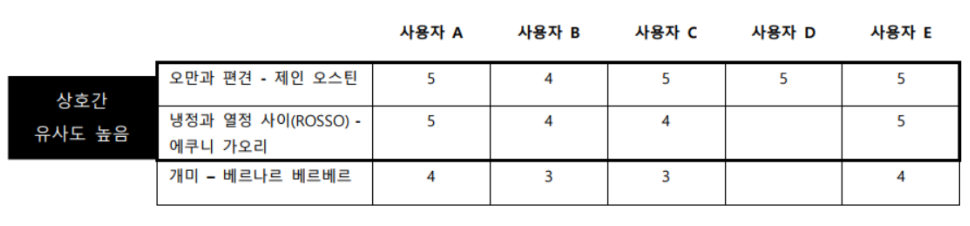

- 위 표에서 제인 오스틴의 고전작 '오만과 편견'과 에쿠니 가오리의 '냉정과 열정 사이'의 독자들의 평점이 유사합니다.
- 아이템(도서) '오만과 편견'은 '개미'보다 '냉정과 열정 사이'와 사용자들의 평점 분포가 훨씬 더 비슷하므로 '오만과 편견'과 '냉정과 열정 사이'는 아이템 유사도가 상대적으로 매우 높게 나오며, 높은 유사도를 바탕으로 사용자 D에게 '냉정과 열정 사이'를 추천할 수 있습니다.

### NearestNeighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors

# 모델 정의
knn = NearestNeighbors(metric='cosine', algorithm='brute')
# 모델 학습
knn.fit(df.values)
# 결과 예측 
distances, indices = knn.kneighbors(df.values, n_neighbors=3)

- distances는 얼마나 유사한지(가까운지)에 대한 정보입니다.

In [ ]:
distances.shape

(82, 3)

In [ ]:
distances[:5]

array([[0.00000000e+00, 3.38448970e-01, 3.43721751e-01],
       [0.00000000e+00, 3.81875184e-01, 3.90040545e-01],
       [0.00000000e+00, 4.29376316e-01, 4.51018751e-01],
       [9.99200722e-16, 3.35053070e-01, 3.46816050e-01],
       [0.00000000e+00, 4.89772451e-01, 5.20530956e-01]])

- indices는 컨텐츠 index(row의 index) 정보입니다.     
예) `[0, 53, 64]`는 moview_0(48 Hrs.)는 가장 유사한 영화는 moview_53(Sissi)이며, 두번째로 유사한 영화는 moview_64(The Hours)입니다. 

In [ ]:
indices.shape 

(82, 3)

In [ ]:
indices[:5]

array([[ 0, 53, 64],
       [ 1, 10, 28],
       [ 2, 20, 43],
       [ 3, 53, 43],
       [ 4, 58, 55]])

In [ ]:
df.index[0], df.index[53], df.index[64]

('48 Hrs.', 'Sissi', 'The Hours')

In [ ]:
# get the index for '48 Hrs.'
index_for_movie = df.index.tolist().index('48 Hrs.')
# find the indices for the similar movies
sim_movies = indices[index_for_movie].tolist()
# distances between '48 Hrs.' and the similar movies
movie_distances = distances[index_for_movie].tolist()
# the position of '48 Hrs.' in the list sim_movies
id_movie = sim_movies.index(index_for_movie)
# remove '48 Hrs.' from the list sim_movies
# print(f'index_for_movie: {index_for_movie}')
# print(f'sim_movies: {sim_movies}')
sim_movies.pop(index_for_movie)
# remove '48 Hrs.' from the list movie_distances
# print(f'id_movie: {id_movie}')
# print(f'movie_distances: {movie_distances}')
movie_distances.pop(id_movie)
sim_movies = [df.index[idx] for idx in sim_movies]
print('The Nearest Movies to 48 Hrs.:', sim_movies)
print('The Distance from 48 Hrs.:', movie_distances)

The Nearest Movies to 48 Hrs.: ['Sissi', 'The Hours']
The Distance from 48 Hrs.: [0.33844897010133224, 0.34372175067675126]


## 영화 추천 

### user 4에 대한 영화 추천 


In [ ]:
df.head(2)

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,5,0.0,0,4.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,4,4,0,0,3,0.0
5 Card Stud,0,0.0,0,0.0,0.0,0,3.5,0,0,0.0,...,0,0.0,4.0,5,0,0,0,0,0,5.0


In [ ]:
df.columns.tolist().index(4) # 사용자 아이디: 4

2

In [ ]:
# copy df
df4 = df.copy()

# find the nearest neighbors using NearestNeighbors(n_neighbors=3)
number_neighbors = 3
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

# convert user_name to user_index 
user_index = df.columns.tolist().index(4)

# t: movie_title, m: the row number of t in df
for m,t in list(enumerate(df.index)):
  
  # find movies without ratings by 4
  if df.iloc[m, user_index] == 0:
    sim_movies = indices[m].tolist()
    movie_distances = distances[m].tolist()
    
    # Generally, this is the case: indices[3] = [3 6 7]. The movie itself is in the first place.
    # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
    try:
      id_movie = sim_movies.index(m)
      sim_movies.pop(m)
      movie_distances.pop(id_movie) 

    # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
    # Some movies have all 0 ratings and the movies with all 0s are considered the same movies by NearestNeighbors(). 
    # Then,even the movie itself cannot be included in the indices. 
    # For example, indices[3] = [2 4 7] is possible if movie_2, movie_3, movie_4, and movie_7 have all 0s for their ratings.
    # In that case, we take off the farthest movie in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
    except:
      sim_movies = sim_movies[:number_neighbors-1]
      movie_distances = movie_distances[:number_neighbors-1]
        
    # movie_similarty = 1 - movie_distance    
    movie_similarity = [1-x for x in movie_distances]
    movie_similarity_copy = movie_similarity.copy()
    nominator = 0

    # for each similar movie
    for s in range(0, len(movie_similarity)):
      
      # check if the rating of a similar movie is zero
      if df.iloc[sim_movies[s], user_index] == 0:

        # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
        if len(movie_similarity_copy) == (number_neighbors - 1):
          movie_similarity_copy.pop(s)
          
        else:
          movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

      # if the rating is not zero, use the rating and similarity in the calculation
      else:
        nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

    # check if the number of the ratings with non-zero is positive
    if len(movie_similarity_copy) > 0:
      
      # check if the sum of the ratings of the similar movies is positive.
      if sum(movie_similarity_copy) > 0:
        predicted_r = nominator/sum(movie_similarity_copy)

      # Even if there are some movies for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
      # in this case, the predicted rating becomes zero as well  
      else:
        predicted_r = 0

    # if all the ratings of the similar movies are zero, then predicted rating should be zero
    else:
      predicted_r = 0

  # place the predicted rating into the copy of the original dataset
    df4.iloc[m,user_index] = predicted_r

userId 4인 사람에 대해서 df에서는 "48 Hrs." 영화에 대한 평점이 없었지만, df4에서는 3.0이라는 평점이 생성된 것을 확인할 수 있습니다. 

In [ ]:
df.head()

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,5,0.0,0,4.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,4,4,0,0,3,0.0
5 Card Stud,0,0.0,0,0.0,0.0,0,3.5,0,0,0.0,...,0,0.0,4.0,5,0,0,0,0,0,5.0
A Clockwork Orange,3,0.0,3,0.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,3,3,0,0,0,0.0
A Nightmare on Elm Street,3,2.5,0,4.0,0.0,3,0.0,0,0,0.0,...,4,0.0,4.0,3,0,3,0,0,0,0.0
A River Runs Through It,0,0.0,0,0.0,5.0,0,0.0,0,0,0.0,...,0,0.0,4.5,0,0,0,0,0,0,0.0


In [ ]:
df4.head()

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
48 Hrs.,5,0.0,3.0,4.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,4,4,0,0,3,0.0
5 Card Stud,0,0.0,0.0,0.0,0.0,0,3.5,0,0,0.0,...,0,0.0,4.0,5,0,0,0,0,0,5.0
A Clockwork Orange,3,0.0,3.0,0.0,0.0,0,0.0,0,0,0.0,...,4,0.0,0.0,0,3,3,0,0,0,0.0
A Nightmare on Elm Street,3,2.5,3.0,4.0,0.0,3,0.0,0,0,0.0,...,4,0.0,4.0,3,0,3,0,0,0,0.0
A River Runs Through It,0,0.0,5.0,0.0,5.0,0,0.0,0,0,0.0,...,0,0.0,4.5,0,0,0,0,0,0,0.0


### movie_recommender

In [ ]:
def recommend_movies(df_recommender, user, num_recommended_movies):

  print('The list of the Movies {} Has Watched \n'.format(user))

  for m in df[df[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_movies = []

  for m in df[df[user] == 0].index.tolist():

    index_df = df.index.tolist().index(m)
    predicted_rating = df_recommender.iloc[index_df, df_recommender.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Movies \n')
  rank = 1
  for recommended_movie in sorted_rm[:num_recommended_movies]:
    
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1

In [ ]:
# store the original dataset in 'df', and create the copy of df, df1 = df.copy().
def movie_recommender(user, num_recommendation, num_neighbors=3):

  df_recommender = df.copy()

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=num_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0

      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (num_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df_recommender.iloc[m,user_index] = predicted_r

  recommend_movies(df_recommender, user, num_recommendation)

2번 유저에게 4개의 영화 추천 

In [ ]:
movie_recommender(user=2, num_recommendation=4)

The list of the Movies 2 Has Watched 

48 Hrs.
A Clockwork Orange
A Nightmare on Elm Street
Back to the Future Part II
Batman Returns
Big Fish
Cockles and Muscles
Dave Chappelle's Block Party
Live and Let Die
Lost in Translation
Monsoon Wedding
Night on Earth
Once Were Warriors
Psycho
Rebecca
Reservoir Dogs
Romeo + Juliet
Silent Hill
Sissi
Solaris
Terminator 3: Rise of the Machines
The Conversation
The Hours
Three Colors: Red
Wag the Dog


The list of the Recommended Movies 

1: Grill Point - predicted rating:5.0
2: Beauty and the Beast - predicted rating:4.0
3: Jurassic Park - predicted rating:4.0
4: Men in Black II - predicted rating:4.0


7번 유저에게 5개 영화 추천 

In [ ]:
movie_recommender(user=7, num_recommendation=5)

The list of the Movies 7 Has Watched 

A Nightmare on Elm Street
Arlington Road
Batman Returns
Dawn of the Dead
Grill Point
Jurassic Park
Monsoon Wedding
Psycho
Rain Man
Reservoir Dogs
Silent Hill
The 39 Steps
The Conversation
The Hours
The Man with the Golden Arm
The Million Dollar Hotel
The Passion of Joan of Arc
Three Colors: Red
To Kill a Mockingbird


The list of the Recommended Movies 

1: Once Were Warriors - predicted rating:5.0
2: Rope - predicted rating:5.0
3: Sleepless in Seattle - predicted rating:5.0
4: Solaris - predicted rating:5.0
5: Terminator 3: Rise of the Machines - predicted rating:5.0
